In [ ]:
#Algorithmes pour séparer les couteurs en catégories et identifier les pics de performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as pltlines
import matplotlib.colors as colors
import math
import statsmodels.tsa.filters.hp_filter as stat

import seaborn as sns
from datetime import datetime
import time
import scipy

In [2]:
def idealBins (l):
    #Trouve ne bon nombre de batch à utiliser. A force d'essais, on constate qu'au delà de 25, le signal est trop précis pour en tirer une loi lisse, au dessous de 10, ce package n'a plus d'intérêt.
    #Input : l : longueur d'un data frame (ou autre itérable)
    #Output : bins : nombre entier, à entrer dans les arguments de la fonction dens
    
    return int(np.rint(max(min(10+(l-100)/70,25),10))) #+1 batch par 70 personnes, entre 10 et 25. 

In [3]:
def dens(dur,**kwargs):
    #calcule une densité d'un itérable
    #**kwargs vont etre redonnés à la fonction maptplotlib.pyplot.hist 
    #l'argument density est forcé à : True
    #input :  dur, itérable (liste, série...) de dimension 1 contenant les valeurs dont la densité nous intéresse
    #output : dens : array nupmy de dimension 2, dens[0] : abscisses des points, dens[1] : ordonnées des points
    
    #bins = 20 pour un marathon, 
    #bins = 12 pour un 10km
    kwargs['density'] = True
    h=plt.hist(dur, **kwargs)
    xhist = []
    plt.close()
    for i in range (len(h[1])-1):
        x = (h[1][i+1]+h[1][i])/2
        xhist.append(x)
    

    densite=np.zeros((2, len(xhist)))
    densite[0,:] = xhist
    densite[1,:] = h[0]
    return densite


(array([ 2.,  0.,  1.,  0.,  0.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  3.,  1.,  5.,  3.,  7.,  6., 10.,  6.,  8.,  9.,  8.,
        11.,  7.,  6.,  7., 16.,  9., 16., 15., 16., 16., 18., 11., 15.,
        20., 18., 19., 26., 19., 28., 29., 31., 21., 26., 24., 23., 12.,
        28., 22., 20., 19., 26., 20., 15., 29., 20., 23., 17., 11., 10.,
        16., 21., 16., 16., 14., 13., 11., 14.,  7.,  5.,  6.,  5.,  5.,
         8.,  3.,  5.,  6.,  5.,  3.,  3.,  4.,  1.,  1.,  1.,  2.,  1.,
         2.,  2.,  0.,  1.,  0.,  0.,  1.,  2.,  1.]),
 array([-0.10763431, -0.0456045 ,  0.01642531,  0.07845513,  0.14048494,
         0.20251475,  0.26454457,  0.32657438,  0.38860419,  0.450634  ,
         0.51266382,  0.57469363,  0.63672344,  0.69875326,  0.76078307,
         0.82281288,  0.88484269,  0.94687251,  1.00890232,  1.07093213,
         1.13296195,  1.19499176,  1.25702157,  1.31905138,  1.3810812 ,
         1.44311101,  1.50514082,  1.56717064,  1.62920045,  1.691230

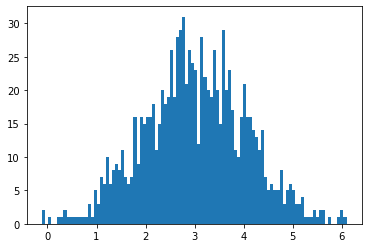

In [65]:
x=np.random.normal(1,1,1000)+np.random.normal(2,0.1,1000)

plt.hist(x, bins = 100)


In [15]:
data=pd.read_csv("10_km_Riorges.csv")
data.head()
dur=data['duration']
bins = idealBins(len(dur))
print(bins)
densite = dens(dur, bins = bins) #densite est un tableau de points avec des abscisses et des ordonnées, comme un histograme


12


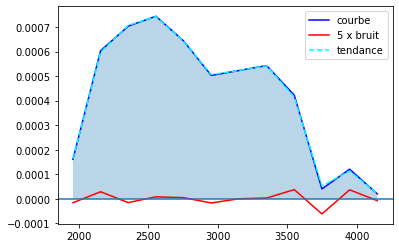

In [16]:
#Ce graphe illustre la différence entre la tendance et le bruit.
#La tendance correspond à la "loi" que suit les temps d'arrivée
#le bruit correspond aux écarts par rapport à cette loi.
#les pics de ce bruit correspondent à des volontés d'atteindre un objectif précis (- de 4h au marathon par ex)
#les vagues de la tendance correspondent à des catégories de coureurs.
brten = separate(densite)
plt.plot(brten[0],densite[1], color = "blue", label = 'courbe')
plt.plot(brten[0],5*brten[1], color = "red", label = '5 x bruit')
plt.plot(brten[0],brten[2], color = "cyan", linestyle = 'dashed',label = 'tendance')
plt.fill_between(brten[0],densite[1], alpha=0.3)
plt.axhline(0)
plt.legend()
plt.show()


In [4]:
def separate(densite):
    #prend en argument un array numpy de valeurs et sépare le signal en "tendance" et "bruit" avec un lambda de 0.1
    #input :  densite : array numpy de dimension 2, taille (k,n)
    #output : array nupmy de dimension 2, taille (k+1,n) où les 2 dernières lignes sont le bruit et la tendance de la derniere ligne de l'input
  
    b,t = stat.hpfilter(densite[-1,:],lamb = 0.01)
    result = np.zeros((len(densite)+1,len(densite[0])))
    result[0:len(densite),:]= densite
    result[-2]= b
    result[-1]=t
    return result



In [5]:
def lissage (x, sep=False, kind = 'cubic',beginend=False): #sans **kwargs pour simplifier son utilisation
    #prend en argument un ensemble de points à interpoler stockés dans un array numpy et retourne la fonction d'interpolation cubique si kind = 'cubic' ou linéaire sinon
    # Input :    x : array numpy de dimension 2, taille(2,n) avec les abscisses des points à interpoler dans x[0] et leurs ordonnées dans x[1]
    #          sep : booléen. True si le signal doit être filtré par un HP filter
    #         kind : 'cubic' pour une interpolation polyonomiale par morceaux, l'interpolation est linéaire sinon
    #     beginend : tuple. Permet de forcer la fonction à prendre des valeurs nulles en beginend[0] et beginend[1]
    # Output :   f : fonction d'une seule variable

    if beginend!=False: #pour imposer des points de début et de fin (ne sert que pour le tracé, pas les calculs !)
        begin=np.zeros((2,1))
        end=np.zeros((2,1))
        begin[0,0] = beginend[0]
        end[0,0] =beginend[-1]

        x=np.concatenate((begin,x,end),axis = 1)
        
    if sep ==True :
        
        t=separate(x)[2]
    else :
        t=x[1]
    if kind == 'cubic':
        poly = scipy.interpolate.splrep(x[0],t)
        def f (X):
            return np.maximum(scipy.interpolate.splev(X,poly, der=0),0) #le max sert à faire des graphes où la densité est toujours positive
        
    else :
        interp=(scipy.interpolate.interp1d(x[0],t, kind='linear',fill_value='extrapolate'))
        def f (X):
            return interp(X)
            
    return f


In [6]:
# begin=np.zeros((2,1))
# end=np.zeros((2,1))
# begin[0,0] = dur[0]
# end[0,0] =list(dur)[-1]
# print(f'begin :\n{begin}')
# print(f'end : \n{end}')
# print(f'densite : \n{densite}')

# x=np.concatenate((begin,densite,end),axis = 1)
# print(f'densite : \n{x}')
# print(x[1])
# poly = scipy.interpolate.splrep(x[0],x[1])


In [7]:
def perfgoals(A):
    #Fonction qui retrouve les pics de densité dans une distribution estimée, et les rend dans leur ordre d'importance
    #input :        A : array numpy de dimension 2, taille (2,n) avec A[0] les abscisses et A[1] les ordonnées des points mesurés
    #output :  result : array numpy de dimension 2, taille (2,k) avec result[0] les abscisses des pics et result[1] les valeurs de la densite en ces points
    #                   l'output est trié par ordre d'importance (hauteur des pics)
    signal=separate(A)
    poly = scipy.interpolate.splrep(signal[0], signal[1])
    #derivee du bruit
    def f1(x): 
        return 1e2*scipy.interpolate.splev(x, poly, der = 1)
    #derivee seconde pour la concavite
    def f2(x):
        return 1e2*scipy.interpolate.splev(x, poly, der = 2)
    guess = signal[0] #on s'attend à ce que les points critiques soient proches des points où la é est mesurée
    roots = scipy.optimize.root(f1, guess).x #trouve les zéros de f1
#dans le cadre du cours, il est meilleur d'utiliser un pd.Series, et de sélectionner les valeurs à l'aide d'un vecteur booléen. plutôt que de travailler sur un array ou une liste
    r=pd.Series(roots)
    bools=abs(f1(r))<1e-4
#     print(f'bools : {bools}')
    r=r[bools]
#     print(f'vraies racines :\n{r}')
    #Les algorithmes de racines trouvent plusieurs fois les mêmes racines, à epsilon près. Supression des doublons:
    r=np.rint(r) #rint (entier le plus proche) permet de se limiter aux valeurs entières et eliminer les doublons dûs à scipy.optimize.root
#     print(f'arrondis : {r}')
    r.drop_duplicates(inplace=True)
#     print(f'dédoubloné :\n{r}')
    r.sort_values(inplace=True)
#     print((f"sorted : \n{r}"))

    #élimination des valeurs hors bornes:
    bool1=r>A[0,0] 
    bool2=r<A[0,-1]
#     print(bool1)
#     print(bool2)
#     print(bool1*bool2)
    
    roots=list(r[bool1*bool2])
#     print(f"racines valables : {roots}")
#----------------------------- Ancienne méthode non robuste
#     print(f"racines : {roots}")
#     roots = list(set(np.rint(roots))) #floor permet de se limiter aux valeurs entieres et eliminer les doublons dus a scipy.optimize.root
#     print(f"floor : {roots}")
#     roots=sorted(roots) 
#     print((f"sorted : {roots}"))
#-----------------------------
    tops = []
    for i in range (len(roots)):
        if f2(roots[i])<0:       #selection des maximums parmi les points critiques
            tops.append(roots[i])
#     print(tops)
    realTops = []
    for i in tops:
        ind=np.argmin(abs(signal[0]-i))
#         print(f'Comparaison : {signal[0,ind]} , {i}')
        realTops=realTops+[signal[0, ind]]
        
    #tri par ordre d'importance    
    bruit = signal[0:2,:]
    g = lissage (bruit, sep=False, kind = 'linear') 
    values = g(realTops)
    sortedTops=np.take(realTops,np.argsort(values))
    sortedTops=np.flip(sortedTops)
    values = np.flip(np.sort(values))
    
    
    h = lissage (A, sep=False, kind = 'linear') #pour retrouver les vraies valeurs aux points approximés. Les vraies valeurs sont recalculées plutôt que lues
    result = np.zeros((2, len(sortedTops)))
    result[0,:]=sortedTops
    result[1,:]=h(sortedTops)
    
    return result
    
    

In [8]:
def topbotts(A, sort = 'performance'):
    #retourne une liste contenant les abscisses des maxima locaux et une autre contenant les abscisses des minima locaux
    #Inputs : A : array numpy de dimension 2, taille (2,n) avec A[0] les abscisses et A[1] les ordonnées des points mesurés
    #      sort : façon de trier les outputs.
    #             -Soit par ordre croissant des abscisses ('performance') 
    #             -Soit par ordre croissant de courbure, les clusters les plus distincts ('values')
    #Outputs : tops, botts : tupple de listes d'abscisses contenant sommets et creux.
    
    signal=separate(A)
    
    poly = scipy.interpolate.splrep(signal[0], signal[2]) #interpolation polynomiale par morceaux de la tendance
    
    def f1(x):
        return 1e3*scipy.interpolate.splev(x, poly, der = 1) #derivee de la fonction de tendance
    def f2(x):
        return 1e3*scipy.interpolate.splev(x, poly, der = 2) #derivee seconde (pour tests de concavite)

    tendance = np.take(signal,[0,2], axis=0)
    guess = A[0] #on s'attend à ce que les racines de f1 soient proches des abscisses originales, puisque les maximums originaux en font partie
    roots = scipy.optimize.root(f1, guess).x #trouve les points critiques de f
#    print(f"racines : {roots}\n")
    
    

#parfois, scipy.optimize.roots trouve des "racines" qui ne le sont pas il faut nettoyer ces données:

#dans le cadre du cours, il est meilleur d'utiliser un pd.Series, et de sélectionner les valeurs à l'aide d'un vecteur booléen. plutôt que de travailler sur un array ou une liste
    r=pd.Series(roots)
    bools=abs(f1(r))<1e-4
#     print(f'bools : {bools}')
    r=r[bools]
#     print(f'vraies racines :\n{r}')
    #Les algorithmes de racines trouvent plusieurs fois les mêmes racines, à epsilon près. Supression des doublons:
    r=np.rint(r) #rint (entier le plus proche) permet de se limiter aux valeurs entières et eliminer les doublons dûs à scipy.optimize.root
#     print(f'arrondis : {r}')
    r.drop_duplicates(inplace=True)
#     print(f'dédoubloné :\n{r}')
    r.sort_values(inplace=True)
#     print((f"sorted : \n{r}"))

    #élimination des valeurs hors bornes:
    bool1=r>A[0,0] 
    bool2=r<A[0,-1]
#     print(bool1)
#     print(bool2)
#     print(bool1*bool2)
    
    roots=list(r[bool1*bool2])
#     print(f"racines valables : {roots}")
    tops = [] #selection des valeurs où f est concave : les maximums
    botts = []
    for i in range (len(roots)):
        if f2(roots[i])<0:
            tops.append(roots[i])
        else :
            botts.append(roots[i])


#     print(f'tops : {tops}') 
#     print(f'botts : {botts}') 
#partie si on veut obtenir les valeurs approchées par les abscisses originales.    
#     realTops = [] #valeur réelle la plus proche 
#     for i in tops:
#         ind=np.argmin(abs(tendance[0]-i))
#         print(f'Comparaison : {tendance[0,ind]} , {i}')
#         realTops=realTops+[tendance[0, ind]]
        
#     realBotts = []
#     for i in botts:
#         ind=np.argmin(abs(tendance[0]-i))
#         print(f'Comparaison : {tendance[0,ind]} , {i}')
#         realBotts=realBotts+[tendance[0, ind]]
        
#     tops=realTops
#     botts=realBotts

    botts=sorted(botts) #devrait être inutile par construction, mais comme scipy.optimize.roots est boîte-noire, je préfère le metttre.
    if sort == 'performance': #devrait être inutile par construction
        tops= sorted(tops)
#tri par ordre de courbure : plus la courbure (f2) est grande en norme, meilleurs sont les points (c'est à dire que la concentration est plus flagrante)
    if sort == 'values':
        values = f2(tops)
        ind=np.argsort(values)
        tops=np.take(tops, ind, axis=0)
        values = sorted(values)
#         print(f'values{values}')
#         print(f'tops{tops}')
    
    return tops, botts



In [9]:
def limiters (A, **kwargs):
    #forme les zones distinctes (catégories de coureurs) à partir de listes de sommets et creux:
    #Inputs : A : array numpy de dimension 2, taille (2,n) avec A[0] les abscisses et A[1] les ordonnées des points mesurés
    #  **kwargs : arguments donnés à topbot. enpratique : sort='performance' ou sort='values'
    #Output : lim : liste de tupple avec les zones de forme [(inf1,sup1), (inf2,sup2)...]
    
    tops, botts=topbotts (A,**kwargs)

    
    lim = [] 
    for i in tops :
        under = A[0,0]
        test = False
        j=0
        while j <(len(botts)) and test==False:
            if botts[j]<i:
                under = botts[j]
                j+=1
            else:
                test=True

        over = A[0,-1]
        test=False
        j=len(botts)-1
        while j>=0 and test==False:
            if botts[j]>i:
                over = botts[j]
                j-=1
            else:
                test=True
        lim.append((under,over))
    print(lim)
    return lim

In [10]:
def taille_categorie(densi,limits):
    #calcule la proportions de coureurs dans une catégorie donnée par limits, arrondie au centième
    #Input : densi : Array numpy de dimension 2, taille (2,n) avec A[0] les abscisses et A[1] les ordonnées des points mesurés d'une densité
    #       limits : tuple de forme (borne_inf, forne_sup)
    #output : integ :float
    f=lissage(densi)
    integ=scipy.integrate.quad(f,limits[0],limits[1])
    return np.rint(100*integ[0])/100
    